# Predicting T1D using Machine Learning Algorithms

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# load dataset and labels
data_file_path = "/Users/asmakhimani/Downloads/diabetes_Dataset_Team_ML.csv"
labels_file_path = "/Users/asmakhimani/Downloads/Diabetes_T1_labels.txt"
data = pd.read_csv(data_file_path)
labels = pd.read_csv(labels_file_path, delimiter='\t')

In [3]:
# preview dataset 
print(data.head())

        ID  Ancestry_African  Ancestry_Any other Asian background  \
0  5713894               0.0                                  0.0   
1  2048882               0.0                                  0.0   
2  1748132               0.0                                  0.0   
3  3772083               0.0                                  0.0   
4  4376107               0.0                                  0.0   

   Ancestry_Any other Black background  Ancestry_Any other mixed background  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   Ancestry_Any other white background  Ancestry_Asian or Asian British  \
0                                  

In [4]:
# preview labels 
print(labels.head())

    UKB ID  time_window_incident/nan/1.0/nan/av1  \
0  5713894                                   0.0   
1  2048882                                   0.0   
2  1748132                                   0.0   
3  3772083                                   0.0   
4  4376107                                   0.0   

   time_window_incident/nan/2.0/nan/av1  time_window_incident/nan/3.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   time_window_incident/nan/4.0/nan/av1  time_window_incident/nan/5.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.

In [5]:
# filter for british ancestry 
data = data[data['Ancestry_British'] == 1]

In [6]:
# how many british ancestry patients
int(data['Ancestry_British'].sum())

442574

In [7]:
# drop nan values from data
data = data.dropna()

In [8]:
# join dataset based on patient ids
# use left join to keep filtered data 
joined_data = pd.merge(data, labels[['UKB ID', 'time_window_incident/nan/10.0/nan/av1']], left_on='ID', right_on='UKB ID', how='left')

In [9]:
# drop ukb id column
joined_data = joined_data.drop(columns=['UKB ID'])

In [10]:
# drop nan values
joined_data = joined_data.dropna(subset=['time_window_incident/nan/10.0/nan/av1'])

In [11]:
# list of joined dataset columns
print(list(joined_data.columns))

['ID', 'Ancestry_African', 'Ancestry_Any other Asian background', 'Ancestry_Any other Black background', 'Ancestry_Any other mixed background', 'Ancestry_Any other white background', 'Ancestry_Asian or Asian British', 'Ancestry_Bangladeshi', 'Ancestry_Black or Black British', 'Ancestry_British', 'Ancestry_Caribbean', 'Ancestry_Chinese', 'Ancestry_Do not know', 'Ancestry_Indian', 'Ancestry_Irish', 'Ancestry_Mixed', 'Ancestry_Other ethnic group', 'Ancestry_Pakistani', 'Ancestry_Prefer not to answer', 'Ancestry_White', 'Ancestry_White and Asian', 'Ancestry_White and Black African', 'Ancestry_White and Black Caribbean', 'f.21022.0.0', 'f.21001.0.0', 'f.904.0.0', 'f.904.0.0_Do not know', 'f.904.0.0_Prefer not to answer', 'f.20107_Father_Lung cancer', 'f.20107_Father_Bowel cancer', 'f.20107_Father_Prostate cancer', 'f.20107_Father_High blood pressure', 'f.20107_Father_Diabetes', 'f.20110_Mother_Lung cancer', 'f.20110_Mother_Bowel cancer', 'f.20110_Mother_Breast cancer', 'f.20110_Mother_High 

In [12]:
# dict mapping original column names to their descriptive names
column_renames = {
    'f.21022.0.0': 'Age',
    'f.21001.0.0': 'BMI',
    'f.20107_Father_Diabetes': 'Father has diabetes',
    'f.20110_Mother_Diabetes': 'Mother has diabetes',  
    'f.20116.0.0_Current': 'Current smoker',
    'f.20116.0.0_Previous': 'Former smoker',
    'f.20116.0.0_Never': 'Never smoker', 
    'f.6155_Vitamin D': 'Vitamin D',  
    'f.6145_Death of a close relative': 'Death of family member',
    'f.6145_Serious illness, injury or assault to yourself': 'Serious illness, injury or assault to yourself',
    'f.6145_Serious illness, injury or assault of a close relative': 'Serious illness, injury or assault of a close relative',
    'f.6145_Financial difficulties': 'Financial difficulties',
    'f.6145_Marital separation/divorce': 'Marital separation/divorce',
    'f.6145_Death of a spouse or partner': 'Death of a spouse or partner'
}


In [13]:
# only keep renamed columns in dataframe
filtered_joined_data = joined_data[list(column_renames.keys())]
print(list(filtered_joined_data.columns))

['f.21022.0.0', 'f.21001.0.0', 'f.20107_Father_Diabetes', 'f.20110_Mother_Diabetes', 'f.20116.0.0_Current', 'f.20116.0.0_Previous', 'f.20116.0.0_Never', 'f.6155_Vitamin D', 'f.6145_Death of a close relative', 'f.6145_Serious illness, injury or assault to yourself', 'f.6145_Serious illness, injury or assault of a close relative', 'f.6145_Financial difficulties', 'f.6145_Marital separation/divorce', 'f.6145_Death of a spouse or partner']


In [14]:
# rename columns
filtered_joined_data = filtered_joined_data.rename(columns=column_renames)

In [15]:
# create family history feature 

# combine 'Father has diabetes' and 'Mother has diabetes' into 'Family history'
filtered_joined_data['Family history'] = ((filtered_joined_data['Father has diabetes'] == 1) | (filtered_joined_data['Mother has diabetes'] == 1)).astype(int)

# drop the original parent diabetes columns
filtered_joined_data = filtered_joined_data.drop(columns=['Father has diabetes', 'Mother has diabetes'])

In [16]:
# create stress feature

stress_columns = [
    'Death of family member', 
    'Serious illness, injury or assault to yourself', 
    'Serious illness, injury or assault of a close relative',
    'Financial difficulties',
    'Marital separation/divorce',
    'Death of a spouse or partner'
]

# combine all stress columns in one binary feature 
filtered_joined_data['stress'] = filtered_joined_data[stress_columns].max(axis=1).astype(int)

# drop the original individual stress columns
filtered_joined_data = filtered_joined_data.drop(columns=stress_columns)

In [17]:
# create smoking feature 

# 1 for current smokers, 0 for former smokers, -1 for never smokers
filtered_joined_data['smoking'] = filtered_joined_data.apply(
    lambda row: 1 if row['Current smoker'] == 1 else (0 if row['Former smoker'] == 1 else -1), axis=1
).astype(int)

# drop the original smoking related columns
filtered_joined_data = filtered_joined_data.drop(columns=['Current smoker', 'Never smoker', 'Former smoker'])


In [18]:
# scaling age and bmi
scaler = StandardScaler()
filtered_joined_data[['Age', 'BMI']] = scaler.fit_transform(filtered_joined_data[['Age', 'BMI']])

In [19]:
# convert the vitamin d column to integers
filtered_joined_data['Vitamin D'] = filtered_joined_data['Vitamin D'].astype(int)

In [20]:
# add target column to dataframe 
filtered_joined_data['target'] = joined_data['time_window_incident/nan/10.0/nan/av1'].astype(int)

# verify dataframe changes
print(filtered_joined_data.head())

        Age       BMI  Vitamin D  Family history  stress  smoking  target
0  0.420212  1.473980          0               0       1       -1       0
1 -0.329852 -1.005537          1               1       1       -1       0
2  0.920254 -0.886758          0               0       0       -1       0
3 -1.204926 -0.810400          0               0       0       -1       0
4  1.420296 -0.574962          0               0       1       -1       0


In [21]:
# how many patients have T1D 
label_counts = filtered_joined_data['target'].value_counts()
print(label_counts)

target
0    417017
1      2777
Name: count, dtype: int64


In [22]:
# train test split

# seperate features and target
X = filtered_joined_data.drop(columns=['target'])
y = filtered_joined_data['target']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [153]:
# # scaling age and bmi
# scaler = StandardScaler()
# X_train[['age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
# X_test[['age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

In [180]:
# # address class imbalance 

# # apply smote
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # check values after smote 
# print("class distribution after smote:")
# print(pd.Series(y_train_resampled).value_counts())

class distribution after smote:
target
0    375315
1    375315
Name: count, dtype: int64


## Random Forest 

In [23]:
# rf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=5,               
#     min_samples_split=5,     
#     min_samples_leaf=1,       
#     class_weight='balanced',
#     random_state=42
# )

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [26]:
# evaluation before hyperparameter optimization
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_prob))

Accuracy: 0.9867475523864728
Confusion Matrix:
 [[124264    842]
 [   827      6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    125106
           1       0.01      0.01      0.01       833

    accuracy                           0.99    125939
   macro avg       0.50      0.50      0.50    125939
weighted avg       0.99      0.99      0.99    125939

AUC:
 0.5345794161509023


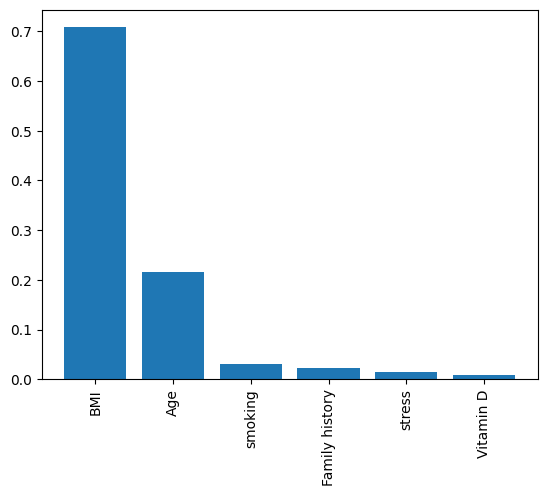

In [27]:
# check feature importance
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.show()

## Hyperparameter Optimization

### Random Search

In [28]:
# perform random search to find best parameters

# parameter combinations
params = {
    'n_estimators': [100, 200, 300],               
    'max_depth': [5, 10, 15, None],              
    'min_samples_split': [2, 5, 10],                
    'min_samples_leaf': [1, 2, 5],                 
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}] 
}

rf = RandomForestClassifier(random_state=42)

# random search
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=params, 
    n_iter=20,  # number of combinations
    cv=5, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1, 
    verbose=2
)

# fit 
random_search.fit(X_train, y_train)

# get best paramenters for model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_
print("best parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   6.9s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   7.0s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   7.1s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   7.1s
[CV] END class_weight={0: 1, 1: 5}, max_depth

In [29]:
# best model predictions
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

In [30]:
# evaluate metrics of best params rf model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

Confusion Matrix:
 [[88865 36241]
 [  273   560]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83    125106
           1       0.02      0.67      0.03       833

    accuracy                           0.71    125939
   macro avg       0.51      0.69      0.43    125939
weighted avg       0.99      0.71      0.82    125939

AUC: 0.7485


### Grid Search

In [185]:
# # Perform Grid Search on Random Forest Model
# rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Avg AUC:", grid_search.best_score_) #Avg Score on 5 fold cross validation across all folds
# print("----------")
# print("\n\n\n")

# # Evaluate the model with the best hyperparameters on the test set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# y_prob = best_model.predict_proba(X_test)[:, 1]

# # Print evaluation metrics
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("AUC:\n", roc_auc_score(y_test, y_prob))

KeyboardInterrupt: 

## Plots

Age: 0.1832
BMI: 0.6461
Vitamin D: 0.0035
Family history: 0.0897
stress: 0.0191
smoking: 0.0583


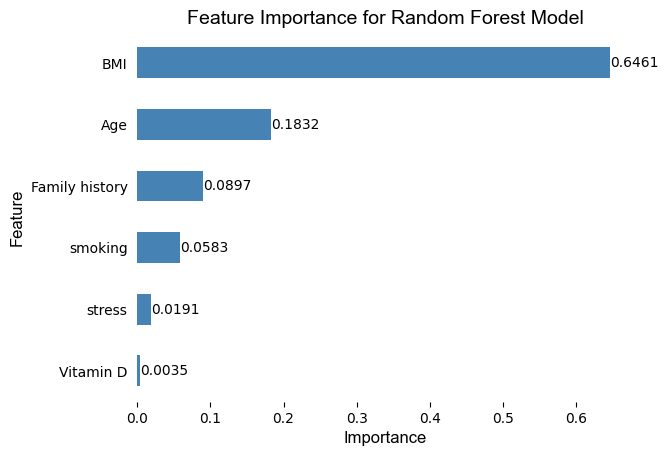

In [31]:
# plotting feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)

# print out importance data weights 
for feature, importance in feature_importances.items():
    print(f'{(feature)}: {importance:.4f}')

# sort feature importances by importance (descending order)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# plotting the top features
ax = feature_importances_sorted.plot(kind='barh', color='#4682B4')

# highest importance feature on top
plt.gca().invert_yaxis()

# set font
font = {'fontname': 'Arial'}

# add axis labels
plt.xlabel('Importance', **font, fontsize=12)
plt.ylabel('Feature', **font, fontsize=12)

# add title
ax.set_title('Feature Importance for Random Forest Model', loc='center', **font, fontsize=14)

# remove borders
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# remove y-axis ticks
ax.tick_params(axis='y', which='both', left=False)
    

# add data weights
for i, value in enumerate(feature_importances_sorted):
    ax.text(value, i, f'{value:.4f}', color='black', va='center')

# save as .png file
plt.savefig('feature_importance_rf_model_T1D.png', bbox_inches='tight')
plt.show()

[[88865 36241]
 [  273   560]]


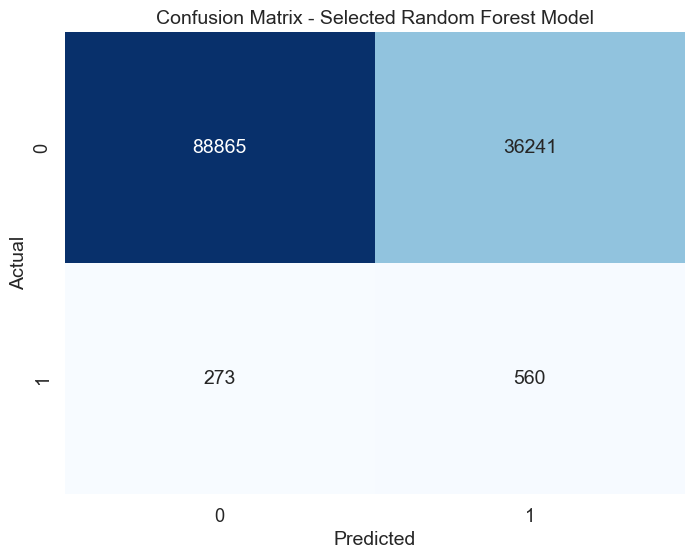

In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 

# plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'], 
            annot_kws={"size": 14}, vmin=0, vmax=cm.max())

# add labels, title, and show the plot
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Selected Random Forest Model', fontsize=14)
plt.savefig('confusion_matrix_rf_model_T1D.png')
plt.show()